In [2]:
#!pip install grpcio==1.24.3


In [3]:
import tensorflow as tf
from IPython.display import Markdown, display



2025-01-13 17:04:00.826604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 17:04:00.827182: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 17:04:00.831146: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 17:04:00.842944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736784240.863093   10755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736784240.86

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [6]:
y_train = tf.one_hot(y_train, 10)#Classe 2 → [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#Classe 5 → [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
y_test = tf.one_hot(y_test, 10)

2025-01-13 17:04:04.402118: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## CNN

In [7]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [8]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])     # batch number, width, height, image channels
x_image_train = tf.cast(x_image_train, 'float32')

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)


In [9]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])    # input_, begin, size
y_train = tf.slice(y_train,[0,0],[10000, 10])

## Convolutional layer 1

In [10]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))    # kernel size, input_channels, output_channels
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs -> [0.1 0.1 ... 0.1]

In [11]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [12]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

In [13]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

## Convolutional layer 2

In [14]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [15]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [16]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

In [30]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

## Convolutional layer 3

In [31]:
W_conv3 = tf.Variable(tf.random.truncated_normal([3, 3, 64, 128], stddev=0.1, seed=2))
b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))  # 128 biases for 128 outputs

def convolve3(x): 
    return tf.nn.conv2d(conv2(x), W_conv3, strides=[1, 1, 1, 1], padding='SAME') + b_conv3

def h_conv3(x): 
    return tf.nn.relu(convolve3(x))

def conv3(x):  
    return tf.nn.max_pool(h_conv3(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


## Fully connected layer

In [32]:
def layer2_matrix(x): 
    return tf.reshape(conv3(x), [-1, 4 * 4 * 128])  # Adjusted to match the output size of the third laye

In [33]:
W_fc1 = tf.Variable(tf.random.truncated_normal([4 * 4 * 128, 1024], stddev=0.1, seed=3))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [34]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [35]:
def h_fc1(x): return tf.nn.relu(fcl(x))

In [36]:
keep_prob=0.5    #Dropout Layer, Optional phase for reducing overfitting
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

In [37]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
# second hidden layer 1024 -> output 10 
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # for 10 outputs (digits [0,1,2,3,4,5,6,7,8,9])

In [38]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [39]:
def y_CNN(x): return tf.nn.softmax(fc(x))    # return possiblities for 10 outputs

## Define functions and train the model

In [40]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [41]:
#optimizer = tf.keras.optimizers.Adam()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Ajuste la valeur du learning rate


In [42]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()

In [43]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))
# argmax: returns index of output with highest possibility

In [44]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

## Run session, train

In [45]:
# Variables pour stocker les métriques
loss_values = []
accuracies = []

# Définir les paramètres d'entraînement
epochs = 10  # Nombre d'itérations
accuracy_metric = tf.keras.metrics.Accuracy()

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    epoch_accuracy = 0
    batches = 0

    for x_train_batch, y_train_batch in train_ds2:
        current_loss = train_step(x_train_batch, y_train_batch)

        # Si current_loss est un tenseur, on récupère la valeur en tant que float
        if isinstance(current_loss, tf.Tensor):
            current_loss = current_loss.numpy()  # Convertir en numpy si c'est un Tensor

        # Calcul de la précision pour ce batch
        predictions = tf.argmax(y_CNN(x_train_batch), axis=1)
        accuracy_metric.update_state(tf.argmax(y_train_batch, axis=1), predictions)

        epoch_loss += current_loss
        batches += 1

        if batches % 10 == 0:
            print(f"Batch {batches}: Loss = {current_loss:.4f}, Accuracy = {accuracy_metric.result().numpy():.4f}")

    epoch_accuracy = accuracy_metric.result().numpy()
    accuracy_metric.reset_state()  # Reset after each epoch

    epoch_loss /= batches
    loss_values.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"End of Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

# Évaluation finale sur le jeu de test
test_accuracy_metric = tf.keras.metrics.Accuracy()

for x_test_batch, y_test_batch in test_ds2:
    predictions = tf.argmax(y_CNN(x_test_batch), axis=1)
    test_accuracy_metric.update_state(tf.argmax(y_test_batch, axis=1), predictions)

final_test_accuracy = test_accuracy_metric.result().numpy()
print(f"\nFinal Test Accuracy: {final_test_accuracy:.4f}")



Epoch 1/10
Batch 10: Loss = 379.5764, Accuracy = 0.2180
Batch 20: Loss = 234.0317, Accuracy = 0.2510
Batch 30: Loss = 103.2275, Accuracy = 0.2887
Batch 40: Loss = 77.3452, Accuracy = 0.3465
Batch 50: Loss = 39.2379, Accuracy = 0.4196
Batch 60: Loss = 30.4228, Accuracy = 0.4783
Batch 70: Loss = 30.4308, Accuracy = 0.5263
Batch 80: Loss = 16.1701, Accuracy = 0.5658
Batch 90: Loss = 35.1276, Accuracy = 0.5958
Batch 100: Loss = 28.4692, Accuracy = 0.6218
Batch 110: Loss = 8.1883, Accuracy = 0.6447
Batch 120: Loss = 14.2731, Accuracy = 0.6652
Batch 130: Loss = 42.4605, Accuracy = 0.6806
Batch 140: Loss = 16.6061, Accuracy = 0.6934
Batch 150: Loss = 13.9689, Accuracy = 0.7045
Batch 160: Loss = 22.0505, Accuracy = 0.7165
Batch 170: Loss = 21.9345, Accuracy = 0.7267
Batch 180: Loss = 13.6834, Accuracy = 0.7343
Batch 190: Loss = 16.1868, Accuracy = 0.7424
Batch 200: Loss = 14.5246, Accuracy = 0.7504
Batch 210: Loss = 8.9583, Accuracy = 0.7577
Batch 220: Loss = 20.1418, Accuracy = 0.7659
Batch 

2025-01-13 17:07:51.042616: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Batch 10: Loss = 3.0229, Accuracy = 0.9640
Batch 20: Loss = 5.7640, Accuracy = 0.9630
Batch 30: Loss = 1.9181, Accuracy = 0.9567
Batch 40: Loss = 1.9015, Accuracy = 0.9620
Batch 50: Loss = 3.2693, Accuracy = 0.9628
Batch 60: Loss = 1.1685, Accuracy = 0.9637
Batch 70: Loss = 2.1029, Accuracy = 0.9646
Batch 80: Loss = 1.7072, Accuracy = 0.9657
Batch 90: Loss = 7.3505, Accuracy = 0.9662
Batch 100: Loss = 13.4802, Accuracy = 0.9668
Batch 110: Loss = 3.1626, Accuracy = 0.9667
Batch 120: Loss = 2.3021, Accuracy = 0.9662
Batch 130: Loss = 21.3469, Accuracy = 0.9666
Batch 140: Loss = 2.7602, Accuracy = 0.9663
Batch 150: Loss = 6.0081, Accuracy = 0.9657
Batch 160: Loss = 5.8153, Accuracy = 0.9656
Batch 170: Loss = 11.1369, Accuracy = 0.9659
Batch 180: Loss = 2.6255, Accuracy = 0.9650
Batch 190: Loss = 9.8524, Accuracy = 0.9651
Batch 200: Loss = 1.3264, Accuracy = 0.9650
Batch 210: Loss = 6.9810, Accuracy = 0.9643
Batch 220: Loss = 14.1537, Accuracy = 0.9647
Batch 230: Loss = 4.6702, Accuracy = 

2025-01-13 17:10:37.987193: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Batch 10: Loss = 5.9480, Accuracy = 0.9660
Batch 20: Loss = 1.1552, Accuracy = 0.9660
Batch 30: Loss = 0.4314, Accuracy = 0.9713
Batch 40: Loss = 3.4608, Accuracy = 0.9760
Batch 50: Loss = 2.3282, Accuracy = 0.9740
Batch 60: Loss = 8.1052, Accuracy = 0.9740
Batch 70: Loss = 3.5251, Accuracy = 0.9757
Batch 80: Loss = 2.8815, Accuracy = 0.9755
Batch 90: Loss = 9.8279, Accuracy = 0.9756
Batch 100: Loss = 10.5475, Accuracy = 0.9760
Batch 110: Loss = 3.7305, Accuracy = 0.9755
Batch 120: Loss = 1.9242, Accuracy = 0.9755
Batch 130: Loss = 6.9781, Accuracy = 0.9751
Batch 140: Loss = 4.4368, Accuracy = 0.9756
Batch 150: Loss = 4.7150, Accuracy = 0.9751
Batch 160: Loss = 7.2680, Accuracy = 0.9743
Batch 170: Loss = 7.8896, Accuracy = 0.9741
Batch 180: Loss = 4.5355, Accuracy = 0.9733
Batch 190: Loss = 5.8291, Accuracy = 0.9728
Batch 200: Loss = 0.9624, Accuracy = 0.9733
Batch 210: Loss = 4.1210, Accuracy = 0.9730
Batch 220: Loss = 19.8964, Accuracy = 0.9728
Batch 230: Loss = 6.2827, Accuracy = 0.

2025-01-13 17:16:16.750724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Batch 10: Loss = 7.3333, Accuracy = 0.9780
Batch 20: Loss = 1.2956, Accuracy = 0.9790
Batch 30: Loss = 0.8363, Accuracy = 0.9780
Batch 40: Loss = 2.3838, Accuracy = 0.9785
Batch 50: Loss = 4.1267, Accuracy = 0.9804
Batch 60: Loss = 0.1736, Accuracy = 0.9800
Batch 70: Loss = 1.2019, Accuracy = 0.9814
Batch 80: Loss = 0.4591, Accuracy = 0.9825
Batch 90: Loss = 9.8374, Accuracy = 0.9820
Batch 100: Loss = 6.4182, Accuracy = 0.9828
Batch 110: Loss = 0.1161, Accuracy = 0.9824
Batch 120: Loss = 1.3786, Accuracy = 0.9827
Batch 130: Loss = 7.1989, Accuracy = 0.9822
Batch 140: Loss = 3.2601, Accuracy = 0.9819
Batch 150: Loss = 1.8420, Accuracy = 0.9813
Batch 160: Loss = 0.9288, Accuracy = 0.9809
Batch 170: Loss = 4.1967, Accuracy = 0.9814
Batch 180: Loss = 6.5487, Accuracy = 0.9813
Batch 190: Loss = 12.1095, Accuracy = 0.9809
Batch 200: Loss = 0.8498, Accuracy = 0.9808
Batch 210: Loss = 2.3691, Accuracy = 0.9810
Batch 220: Loss = 18.3853, Accuracy = 0.9808
Batch 230: Loss = 4.9225, Accuracy = 0.

2025-01-13 17:27:39.916607: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Batch 10: Loss = 12.0200, Accuracy = 0.9920
Batch 20: Loss = 2.7941, Accuracy = 0.9890
Batch 30: Loss = 0.2968, Accuracy = 0.9867
Batch 40: Loss = 3.2749, Accuracy = 0.9845
Batch 50: Loss = 2.2959, Accuracy = 0.9852
Batch 60: Loss = 0.1162, Accuracy = 0.9857
Batch 70: Loss = 2.3405, Accuracy = 0.9863
Batch 80: Loss = 1.4184, Accuracy = 0.9865
Batch 90: Loss = 10.8494, Accuracy = 0.9867
Batch 100: Loss = 2.1808, Accuracy = 0.9872
Batch 110: Loss = 3.7943, Accuracy = 0.9871
Batch 120: Loss = 0.5406, Accuracy = 0.9872
Batch 130: Loss = 0.6102, Accuracy = 0.9869
Batch 140: Loss = 5.1298, Accuracy = 0.9871
Batch 150: Loss = 2.5546, Accuracy = 0.9872
Batch 160: Loss = 0.9533, Accuracy = 0.9872
Batch 170: Loss = 15.5364, Accuracy = 0.9865
Batch 180: Loss = 1.0423, Accuracy = 0.9869
Batch 190: Loss = 1.0480, Accuracy = 0.9868
Batch 200: Loss = 0.1769, Accuracy = 0.9872
Batch 210: Loss = 0.2100, Accuracy = 0.9873
Batch 220: Loss = 3.7909, Accuracy = 0.9876
Batch 230: Loss = 0.2434, Accuracy = 0

In [31]:
"""# Variables pour stocker les métriques
loss_values = []
accuracies = []

# Définir les paramètres d'entraînement
epochs = 1  # Nombre d'itérations

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_loss = 0
    epoch_accuracy = 0
    batches = 0

    # Boucle sur les batches
    for x_train_batch, y_train_batch in train_ds2:
        # Effectuer une étape d'entraînement
        current_loss = train_step(x_train_batch, y_train_batch)
        
        # Si current_loss est un tenseur TensorFlow, on peut appeler .numpy()
        if isinstance(current_loss, tf.Tensor):
            current_loss = current_loss.numpy()

        # Ajout de la perte au total de l'epoch
        epoch_loss += float(current_loss)  # Assurez-vous que c'est un float natif

        # Calcul de la précision pour ce batch
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                       tf.argmax(y_train_batch, axis=1))
        batch_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Si batch_accuracy est un tenseur TensorFlow
        if isinstance(batch_accuracy, tf.Tensor):
            batch_accuracy = batch_accuracy.numpy()

        epoch_accuracy += float(batch_accuracy)  # Ajoutez à la précision totale
        batches += 1

        # Affichage intermittent
        if batches % 10 == 0:  # Tous les 10 batches
            print(f"Batch {batches}: Loss = {current_loss:.4f}, Accuracy = {batch_accuracy:.4f}")

    # Moyenne des pertes et précisions pour l'epoch
    epoch_loss /= batches
    epoch_accuracy /= batches
    loss_values.append(epoch_loss)
    accuracies.append(epoch_accuracy)

    print(f"End of Epoch {epoch + 1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.4f}")

# Évaluation finale sur le jeu de test
test_accuracy = 0
test_batches = 0

for x_test_batch, y_test_batch in test_ds2:
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_test_batch), axis=1),
                                   tf.argmax(y_test_batch, axis=1))
    batch_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Si batch_accuracy est un tenseur TensorFlow
    if isinstance(batch_accuracy, tf.Tensor):
        batch_accuracy = batch_accuracy.numpy()

    test_accuracy += float(batch_accuracy)
    test_batches += 1

test_accuracy /= test_batches
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")"""


Epoch 1/1
Batch 10: Loss = 388.3102, Accuracy = 0.3200
Batch 20: Loss = 162.3109, Accuracy = 0.2800
Batch 30: Loss = 79.6568, Accuracy = 0.5400
Batch 40: Loss = 51.6647, Accuracy = 0.6400
Batch 50: Loss = 44.8064, Accuracy = 0.7800
Batch 60: Loss = 21.1556, Accuracy = 0.8600
Batch 70: Loss = 35.7018, Accuracy = 0.7800
Batch 80: Loss = 23.3556, Accuracy = 0.7800
Batch 90: Loss = 36.8734, Accuracy = 0.6800
Batch 100: Loss = 28.7849, Accuracy = 0.9000
Batch 110: Loss = 14.1644, Accuracy = 0.9200
Batch 120: Loss = 15.0750, Accuracy = 0.9200
Batch 130: Loss = 35.2015, Accuracy = 0.8400
Batch 140: Loss = 16.0553, Accuracy = 0.9600
Batch 150: Loss = 14.0881, Accuracy = 0.9200
Batch 160: Loss = 27.4198, Accuracy = 0.8600
Batch 170: Loss = 23.4705, Accuracy = 0.8400
Batch 180: Loss = 8.0054, Accuracy = 0.9400
Batch 190: Loss = 18.7697, Accuracy = 0.9400
Batch 200: Loss = 8.2829, Accuracy = 0.9200
Batch 210: Loss = 13.8405, Accuracy = 0.9600
Batch 220: Loss = 14.9241, Accuracy = 0.9200
Batch 23

## Evaluate the model

In [46]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))       

batch 100 accuracy 1.0
batch 200 accuracy 1.0
batch 300 accuracy 0.98
batch 400 accuracy 0.98
batch 500 accuracy 1.0
batch 600 accuracy 1.0
batch 700 accuracy 1.0
batch 800 accuracy 0.98
batch 900 accuracy 0.98
batch 1000 accuracy 0.96
batch 1100 accuracy 1.0
batch 1200 accuracy 1.0
accuracy of entire set 0.9761567


 ## The blue line shows the loss (errors) over time:

It starts high around 6.2
It keeps going down, which is good
By the end, it's much lower at 2.0

The orange line shows accuracy (how often the model is correct):

It starts at about 97%
It keeps improving
By the end, it reaches 99%, which is very good

Overall, this is exactly what we want to see in training:

Loss going down = fewer mistakes
Accuracy going up = better predictions
The changes are smooth, suggesting stable learning

The model appears to be learning well and achieving strong final performance

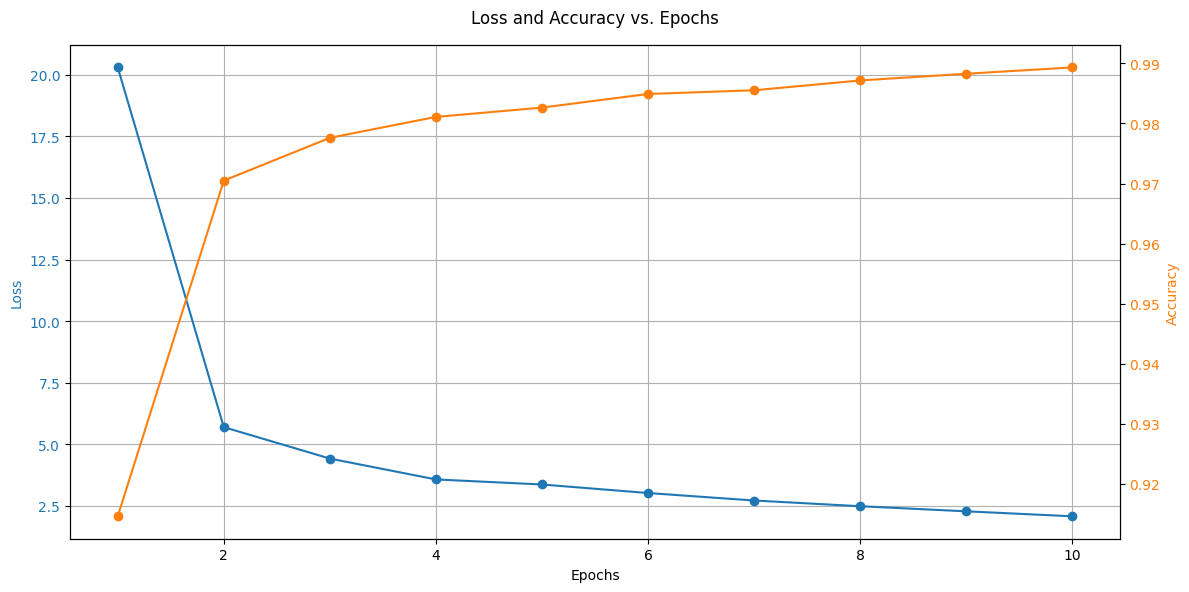

In [49]:
import matplotlib.pyplot as plt
min_length = min(len(loss_values), len(accuracies))
loss_values = loss_values[:min_length]
accuracies = accuracies[:min_length]


fig, ax1 = plt.subplots(figsize=(12, 6))

# Axe pour la perte (Loss)
color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(loss_values) + 1), loss_values, label="Loss", marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Ajouter un deuxième axe pour la précision (Accuracy)
ax2 = ax1.twinx()  # Instancier un second axe qui partage le même axe x
color = 'tab:orange'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, len(accuracies) + 1), accuracies, label="Accuracy", marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
fig.suptitle("Loss and Accuracy vs. Epochs")
fig.tight_layout()  # Ajuste automatiquement les espaces pour éviter les chevauchements
plt.show()


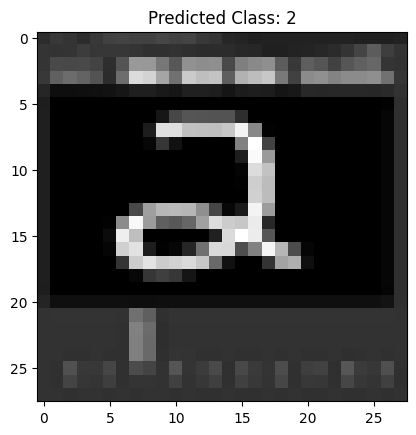

Predicted Class: 2


In [53]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Charger l'image à partir du fichier
image_path = '/home/dhia/presentation_DL/2.png'
image = Image.open(image_path)

# Redimensionner l'image à 28x28 (en fonction de votre modèle)
image = image.resize((28, 28))

# Convertir l'image en niveaux de gris (si ce n'est pas déjà fait)
image = image.convert('L')

# Convertir l'image en un tableau numpy
image_array = np.array(image)

# Normaliser l'image entre 0 et 1 (si votre modèle a été entraîné sur des images normalisées)
image_array = image_array.astype('float32') / 255.0

# Ajouter une dimension pour la batch (le modèle attend une forme de [batch_size, 28, 28, 1])
image_array = np.expand_dims(image_array, axis=-1)

# Ajouter une autre dimension pour le batch (le modèle attend une entrée de forme [1, 28, 28, 1])
image_array = np.expand_dims(image_array, axis=0)

# Passer l'image à travers le modèle pour obtenir la prédiction
prediction = y_CNN(image_array)  # ou utilisez votre propre modèle ici

# Prédire la classe (si votre sortie est une probabilité)
predicted_class = np.argmax(prediction.numpy(), axis=1)

# Afficher l'image et la prédiction
plt.imshow(image, cmap='gray')
plt.title(f"Predicted Class: {predicted_class[0]}")
plt.show()

print(f"Predicted Class: {predicted_class[0]}")


## prediction
Finally, to test and predict our project, we designed an interactive application that allows the user to draw a digit by hand on a digital canvas. The resulting image is resized and normalized to be compatible with our convolutional neural network (CNN) model. Once the drawing is completed, the user can trigger a prediction, which displays the estimated class along with the model's confidence level. This simple and intuitive interface serves as a practical validation of our project.

Classe prédite: 4, Confiance: 23.20%


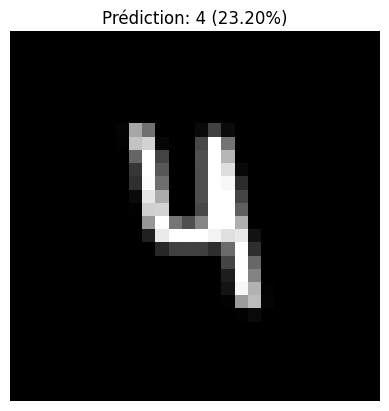

Classe prédite: 3, Confiance: 23.19%


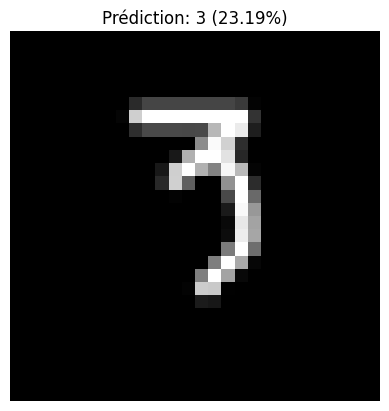

Classe prédite: 4, Confiance: 23.20%


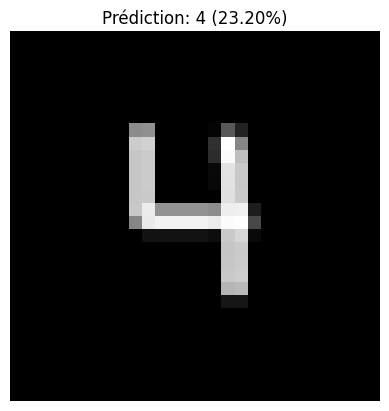

Classe prédite: 9, Confiance: 20.50%


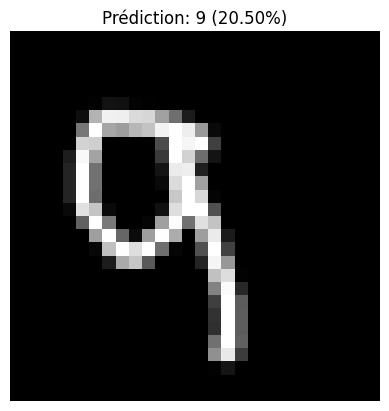

In [54]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import tkinter as tk

# Dimensions pour le canevas et les images
CANVAS_WIDTH = 200
CANVAS_HEIGHT = 200
IMG_SIZE = 28  # Taille cible pour le modèle (28x28)

# Création d'une image PIL pour stocker le dessin
image = Image.new("L", (CANVAS_WIDTH, CANVAS_HEIGHT), "black")
draw = ImageDraw.Draw(image)

# Initialisation de la fenêtre tkinter
root = tk.Tk()
root.title("Dessinez un chiffre")

# Fonction pour dessiner sur le canevas
def paint(event):
    x1, y1 = (event.x - 5), (event.y - 5)
    x2, y2 = (event.x + 5), (event.y + 5)
    canvas.create_oval(x1, y1, x2, y2, fill="white", outline="white")
    draw.ellipse([x1, y1, x2, y2], fill="white")

# Fonction pour effacer le canevas
def clear_canvas():
    canvas.delete("all")
    draw.rectangle([0, 0, CANVAS_WIDTH, CANVAS_HEIGHT], fill="black")

# Fonction pour prédire en temps réel
def predict_image():
    # Redimensionner l'image en 28x28
    img = image.resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img) / 255.0  # Normalisation entre 0 et 1
    img_array = np.expand_dims(img_array, axis=(0, -1))  # Ajouter les dimensions batch et canal

    # Effectuer une prédiction
    prediction = y_CNN(img_array)  # Utiliser directement le modèle pour prédire
    predicted_class = np.argmax(prediction, axis=1)[0]  # Trouver la classe prédite
    confidence = np.max(tf.nn.softmax(prediction)) * 100  # Calculer la confiance

    # Afficher les résultats dans le terminal et la fenêtre matplotlib
    print(f"Classe prédite: {predicted_class}, Confiance: {confidence:.2f}%")

    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title(f"Prédiction: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()

# Création du canevas tkinter
canvas = tk.Canvas(root, width=CANVAS_WIDTH, height=CANVAS_HEIGHT, bg="black")
canvas.pack()

# Lier les événements tkinter
canvas.bind("<B1-Motion>", paint)

# Boutons tkinter pour effacer et prédire
btn_clear = tk.Button(root, text="Effacer", command=clear_canvas)
btn_clear.pack(side=tk.LEFT, padx=10)

btn_predict = tk.Button(root, text="Prédire", command=predict_image)
btn_predict.pack(side=tk.RIGHT, padx=10)

# Lancer la fenêtre tkinter
root.mainloop()
